# Network analysis of Python libraries and AI-related packages

Este notebook constrói uma **rede de dependências entre pacotes Python** e enriquece cada nó com **métricas de vulnerabilidades Snyk**, permitindo comparar:

- **Rede completa de pacotes** (todos os packages do CSV)
- **Sub-rede apenas de libs usadas para IA/ML** (ex.: `torch`, `transformers`, `mlflow`, `langchain`, `vllm`, etc.)

> ⚠️ **Pré-requisitos de arquivos**
>
> - `VULN_CSV`: CSV com as colunas  
>   `package,cve,cwes,severity,first_affected_version,first_affected_date,disclosed_date,mitigation_version,mitigation_date,disclosure_lag_days,time_to_fix_from_first_days,time_to_fix_from_disclosure_days,fix_semver_type`  
>   (é o dataset que você já mostrou).
> - `DEPS_CSV`: CSV com o grafo de dependências entre pacotes, com **uma linha por aresta**:
>   - `source`: pacote que depende (projeto)
>   - `target`: pacote requerido (dependência, o “importado”)
>
> Este notebook **não extrai imports**; ele assume que seu pipeline anterior já gerou esse arquivo de dependências.


In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Apenas para visualização mais amigável
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [8]:
# =========================
# Configurações principais
# =========================

# Caminhos dos arquivos de entrada
VULN_CSV = "outputs/top_pypi_snyk_timeline_20231101_20251101.csv"   # <-- ajuste para o nome real do seu CSV
DEPS_CSV = "python_dependencies_edges.csv"     # <-- ajuste para o arquivo de arestas gerado no pipeline

# Mapa de severidade para valores numéricos
severity_map = {
    "low": 1,
    "moderate": 2,
    "medium": 2,   # caso apareça "medium" em algum lugar
    "high": 3,
    "critical": 4
}

# Lista curada de libs voltadas para IA/ML/LLM presentes no dataset
AI_LIBS = sorted({
    # Núcleo de DL/ML
    "torch", "scikit-learn", "lightgbm", "pytorch-lightning", "keras",
    "paddlepaddle", "onnx", "xgboost",
    # LLM / RAG / LangChain & família
    "transformers", "langchain", "langchain-core", "langchain-community",
    "langchain-experimental", "llama-index", "llama-index-core",
    "llama-index-cli", "vllm", "qdrant-client", "mlflow",
    # MLOps / pipelines / experiment tracking
    "clearml", "feast", "sagemaker", "kedro", "prefect",
    # Interfaces/ferramentas típicas de IA generativa
    "gradio", "streamlit", "browser-use", "ydata-profiling",
    # Outras libs correlatas do seu dataset
    "fastmcp", "litellm", "skops", "lightning", "pytorch-lightning"
})

print(f"Total de libs marcadas como IA: {len(AI_LIBS)}")
AI_LIBS

Total de libs marcadas como IA: 32


['browser-use',
 'clearml',
 'fastmcp',
 'feast',
 'gradio',
 'kedro',
 'keras',
 'langchain',
 'langchain-community',
 'langchain-core',
 'langchain-experimental',
 'lightgbm',
 'lightning',
 'litellm',
 'llama-index',
 'llama-index-cli',
 'llama-index-core',
 'mlflow',
 'onnx',
 'paddlepaddle',
 'prefect',
 'pytorch-lightning',
 'qdrant-client',
 'sagemaker',
 'scikit-learn',
 'skops',
 'streamlit',
 'torch',
 'transformers',
 'vllm',
 'xgboost',
 'ydata-profiling']

In [9]:
# =========================
# Carregar vulnerabilidades Snyk
# =========================

vulns = pd.read_csv(VULN_CSV)

print("Amostra do dataset de vulnerabilidades:")
display(vulns.head())

# Parse de datas
date_cols = ["first_affected_date", "disclosed_date", "mitigation_date"]
for col in date_cols:
    if col in vulns.columns:
        vulns[col] = pd.to_datetime(vulns[col], errors="coerce")

# Garantir colunas numéricas
for col in ["disclosure_lag_days", "time_to_fix_from_first_days", "time_to_fix_from_disclosure_days"]:
    if col in vulns.columns:
        vulns[col] = pd.to_numeric(vulns[col], errors="coerce")

# Severidade numérica
vulns["severity_norm"] = (
    vulns["severity"]
    .astype(str)
    .str.lower()
    .map(severity_map)
)

print("\nResumo de severidade:")
display(vulns["severity"].value_counts(dropna=False))


Amostra do dataset de vulnerabilidades:


,package,cve,cwes,severity,first_affected_version,first_affected_date,disclosed_date,mitigation_version,mitigation_date,disclosure_lag_days,time_to_fix_from_first_days,time_to_fix_from_disclosure_days,fix_semver_type
0,urllib3,CVE-2024-37891,NaN,moderate,0,NaN,2024-06-17,1.26.19,2024-06-17,NaN,NaN,0.0,major
1,urllib3,CVE-2025-50182,NaN,moderate,2.2.0,2024-01-30,2025-06-18,2.5.0,2025-06-18,505.0,505.0,0.0,minor
2,urllib3,CVE-2025-50181,NaN,moderate,0,NaN,2025-06-18,2.5.0,2025-06-18,NaN,NaN,0.0,major
3,requests,CVE-2024-47081,NaN,moderate,0,NaN,2025-06-09,2.32.4,2025-06-09,NaN,NaN,0.0,major
4,requests,CVE-2024-35195,NaN,moderate,0,NaN,2024-05-20,2.32.0,2024-05-20,NaN,NaN,0.0,major



Resumo de severidade:


severity
high        247
moderate    245
critical     69
low          46
unknown      42
Name: count, dtype: int64

In [10]:
# =========================
# Carregar vulnerabilidades Snyk
# =========================

vulns = pd.read_csv(VULN_CSV)

print("Amostra do dataset de vulnerabilidades:")
display(vulns.head())

# Parse de datas
date_cols = ["first_affected_date", "disclosed_date", "mitigation_date"]
for col in date_cols:
    if col in vulns.columns:
        vulns[col] = pd.to_datetime(vulns[col], errors="coerce")

# Garantir colunas numéricas
for col in ["disclosure_lag_days", "time_to_fix_from_first_days", "time_to_fix_from_disclosure_days"]:
    if col in vulns.columns:
        vulns[col] = pd.to_numeric(vulns[col], errors="coerce")

# Severidade numérica
vulns["severity_norm"] = (
    vulns["severity"]
    .astype(str)
    .str.lower()
    .map(severity_map)
)

print("\nResumo de severidade:")
display(vulns["severity"].value_counts(dropna=False))

Amostra do dataset de vulnerabilidades:


,package,cve,cwes,severity,first_affected_version,first_affected_date,disclosed_date,mitigation_version,mitigation_date,disclosure_lag_days,time_to_fix_from_first_days,time_to_fix_from_disclosure_days,fix_semver_type
0,urllib3,CVE-2024-37891,NaN,moderate,0,NaN,2024-06-17,1.26.19,2024-06-17,NaN,NaN,0.0,major
1,urllib3,CVE-2025-50182,NaN,moderate,2.2.0,2024-01-30,2025-06-18,2.5.0,2025-06-18,505.0,505.0,0.0,minor
2,urllib3,CVE-2025-50181,NaN,moderate,0,NaN,2025-06-18,2.5.0,2025-06-18,NaN,NaN,0.0,major
3,requests,CVE-2024-47081,NaN,moderate,0,NaN,2025-06-09,2.32.4,2025-06-09,NaN,NaN,0.0,major
4,requests,CVE-2024-35195,NaN,moderate,0,NaN,2024-05-20,2.32.0,2024-05-20,NaN,NaN,0.0,major



Resumo de severidade:


severity
high        247
moderate    245
critical     69
low          46
unknown      42
Name: count, dtype: int64

In [11]:
# =========================
# Agregar atributos por pacote (nó)
# =========================

agg = (
    vulns
    .groupby("package")
    .agg(
        vuln_count=("cve", "nunique"),  # número de CVEs distintos
        vuln_rows=("cve", "size"),      # número de linhas (inclui linhas sem CVE)
        max_severity=("severity_norm", "max"),
        mean_severity=("severity_norm", "mean"),
        mean_fix_from_disclosure=("time_to_fix_from_disclosure_days", "mean"),
        mean_fix_from_first=("time_to_fix_from_first_days", "mean"),
        first_disclosure=("disclosed_date", "min"),
        last_disclosure=("disclosed_date", "max")
    )
    .reset_index()
)

print("Atributos agregados por pacote:")
display(agg.head())

print("\nTotal de packages distintos com vulnerabilidades:", len(agg))

Atributos agregados por pacote:


,package,vuln_count,vuln_rows,max_severity,mean_severity,mean_fix_from_disclosure,mean_fix_from_first,first_disclosure,last_disclosure
0,adyen,0,1,2.0,2.0,-778.0,930.000000,2024-08-30,2024-08-30
1,agno,1,1,3.0,3.0,-2.0,50.000000,2025-10-31,2025-10-31
2,aiohttp,12,13,3.0,2.0,-69.0,910.666667,2023-11-14,2025-07-14
3,aiomysql,1,1,3.0,3.0,-1.0,NaN,2025-10-22,2025-10-22
4,anki,3,3,3.0,2.0,NaN,NaN,2024-07-22,2024-07-22



Total de packages distintos com vulnerabilidades: 184


In [12]:
# =========================
# Carregar arestas de dependências e construir o grafo
# =========================

deps = pd.read_csv(DEPS_CSV)

print("Amostra do arquivo de dependências:")
display(deps.head())

# Ajuste aqui se suas colunas tiverem outros nomes
SRC_COL = "source"  # projeto que depende
DST_COL = "target"  # dependência requerida

missing_cols = {SRC_COL, DST_COL} - set(deps.columns)
if missing_cols:
    raise ValueError(f"As colunas {missing_cols} não foram encontradas em {DEPS_CSV}. Ajuste SRC_COL/DST_COL.")

# Construir grafo direcionado: source -> target
G = nx.DiGraph()

for _, row in deps.iterrows():
    src = str(row[SRC_COL])
    dst = str(row[DST_COL])
    if src and dst and src != "nan" and dst != "nan":
        G.add_edge(src, dst)

# Garantir que todos os packages vulneráveis apareçam, mesmo que sem arestas
for pkg in agg["package"].astype(str):
    if pkg not in G:
        G.add_node(pkg)

print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

Amostra do arquivo de dependências:


,source,target
0,agno,aiohttp
1,agno,opentelemetry-exporter-otlp-proto-grpc
2,agno,typing-extensions
3,agno,mem0ai
4,agno,google-genai


Grafo criado com 1555 nós e 3463 arestas.


In [13]:
# =========================
# Atribuir atributos aos nós (do DataFrame 'agg')
# =========================

attr_dict = (
    agg
    .set_index("package")
    .to_dict(orient="index")
)

nx.set_node_attributes(G, attr_dict)

# Flag de lib IA
ai_flags = {pkg: (pkg in AI_LIBS) for pkg in G.nodes()}
nx.set_node_attributes(G, ai_flags, "is_ai_lib")

# Verificar exemplo de nó
sample_node = list(G.nodes())[0]
print("Exemplo de nó com atributos:")
print(sample_node, G.nodes[sample_node])

Exemplo de nó com atributos:
agno {'vuln_count': 1, 'vuln_rows': 1, 'max_severity': 3.0, 'mean_severity': 3.0, 'mean_fix_from_disclosure': -2.0, 'mean_fix_from_first': 50.0, 'first_disclosure': Timestamp('2025-10-31 00:00:00'), 'last_disclosure': Timestamp('2025-10-31 00:00:00'), 'is_ai_lib': False}


In [14]:
# =========================
# Métricas de rede
# =========================

# Graus
degree_dict = dict(G.degree())
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())

nx.set_node_attributes(G, degree_dict, "degree")
nx.set_node_attributes(G, in_degree_dict, "in_degree")
nx.set_node_attributes(G, out_degree_dict, "out_degree")

# Betweenness centrality (pode ser custoso em grafos muito grandes)
print("Calculando betweenness centrality (pode demorar um pouco)...")
betweenness_dict = nx.betweenness_centrality(G, normalized=True)
nx.set_node_attributes(G, betweenness_dict, "betweenness")

# Eigenvector centrality (usando versão baseada em álgebra linear)
print("Calculando eigenvector centrality (usando grafo não direcionado)...")
UG = G.to_undirected()
try:
    eigenvector_dict = nx.eigenvector_centrality_numpy(UG)
except Exception as e:
    print("Falha ao calcular eigenvector centrality com método numpy:", e)
    eigenvector_dict = {}

nx.set_node_attributes(G, eigenvector_dict, "eigenvector")

# Densidade da rede (não direcionada)
density = nx.density(UG)
print(f"\nDensidade da rede (não direcionada): {density:.6f}")

# Comunidades e modularidade
print("Calculando comunidades (greedy modularity)...")
from networkx.algorithms import community

communities = list(community.greedy_modularity_communities(UG))
modularity_value = community.modularity(UG, communities)
print(f"Modularidade (greedy): {modularity_value:.6f}")
print(f"Número de comunidades detectadas: {len(communities)}")

Calculando betweenness centrality (pode demorar um pouco)...
Calculando eigenvector centrality (usando grafo não direcionado)...
Falha ao calcular eigenvector centrality com método numpy: `eigenvector_centrality_numpy` does not give consistent results for disconnected graphs

Densidade da rede (não direcionada): 0.002858
Calculando comunidades (greedy modularity)...
Modularidade (greedy): 0.510483
Número de comunidades detectadas: 26


In [15]:
# =========================
# Consolidar atributos de nós em um DataFrame
# =========================

nodes_data = []
for node, data in G.nodes(data=True):
    row = {"package": node}
    row.update(data)
    nodes_data.append(row)

nodes_df = pd.DataFrame(nodes_data)

print("Amostra do DataFrame de nós:")
display(nodes_df.head())

print("\nColunas disponíveis em nodes_df:")
print(nodes_df.columns.tolist())

Amostra do DataFrame de nós:


,package,vuln_count,vuln_rows,max_severity,mean_severity,mean_fix_from_disclosure,mean_fix_from_first,first_disclosure,last_disclosure,is_ai_lib,degree,in_degree,out_degree,betweenness
0,agno,1.0,1.0,3.0,3.0,-2.0,50.000000,2025-10-31,2025-10-31,False,140,1,139,0.000000
1,aiohttp,12.0,13.0,3.0,2.0,-69.0,910.666667,2023-11-14,2025-07-14,False,32,20,12,0.000233
2,opentelemetry-exporter-otlp-proto-grpc,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,False,1,1,0,0.000000
3,typing-extensions,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,False,35,35,0,0.000000
4,mem0ai,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,False,2,2,0,0.000000



Colunas disponíveis em nodes_df:
['package', 'vuln_count', 'vuln_rows', 'max_severity', 'mean_severity', 'mean_fix_from_disclosure', 'mean_fix_from_first', 'first_disclosure', 'last_disclosure', 'is_ai_lib', 'degree', 'in_degree', 'out_degree', 'betweenness']


In [16]:
# =========================
# Comparação: rede completa vs libs de IA
# =========================

nodes_total = nodes_df.copy()
nodes_ai = nodes_df[nodes_df["is_ai_lib"] == True].copy()
nodes_non_ai = nodes_df[nodes_df["is_ai_lib"] == False].copy()

print(f"Total de nós (todos os packages): {len(nodes_total)}")
print(f"Total de nós (libs IA): {len(nodes_ai)}")
print(f"Total de nós (não IA): {len(nodes_non_ai)}")

def describe_metric(df, col):
    return df[col].describe().to_frame(name=col)

metrics_to_compare = ["degree", "in_degree", "out_degree", "betweenness", "eigenvector", "max_severity", "mean_fix_from_disclosure"]

summary_total = pd.concat(
    [describe_metric(nodes_total, m) for m in metrics_to_compare if m in nodes_total.columns],
    axis=1
)

summary_ai = pd.concat(
    [describe_metric(nodes_ai, m) for m in metrics_to_compare if m in nodes_ai.columns],
    axis=1
)

summary_non_ai = pd.concat(
    [describe_metric(nodes_non_ai, m) for m in metrics_to_compare if m in nodes_non_ai.columns],
    axis=1
)

print("\nResumo das métricas - REDE COMPLETA:")
display(summary_total)

print("\nResumo das métricas - LIBS IA:")
display(summary_ai)

print("\nResumo das métricas - NÃO IA:")
display(summary_non_ai)

Total de nós (todos os packages): 1555
Total de nós (libs IA): 32
Total de nós (não IA): 1523

Resumo das métricas - REDE COMPLETA:


,degree,in_degree,out_degree,betweenness,max_severity,mean_fix_from_disclosure
count,1555.000000,1555.000000,1555.000000,1555.000000,184.000000,166.000000
mean,4.454019,2.227010,2.227010,0.000009,2.788043,-52.949123
std,11.239051,3.947277,10.458869,0.000088,0.832186,169.839322
min,0.000000,0.000000,0.000000,0.000000,1.000000,-961.000000
25%,1.000000,1.000000,0.000000,0.000000,2.000000,-49.275000
50%,1.000000,1.000000,0.000000,0.000000,3.000000,-7.000000
75%,2.000000,2.000000,0.000000,0.000000,3.000000,-0.666667
max,144.000000,52.000000,143.000000,0.002234,4.000000,537.000000



Resumo das métricas - LIBS IA:


,degree,in_degree,out_degree,betweenness,max_severity,mean_fix_from_disclosure
count,32.000000,32.000000,32.000000,32.000000,31.000000,28.000000
mean,35.468750,2.218750,33.250000,0.000186,3.419355,-46.178039
std,32.557626,2.848139,32.395738,0.000470,0.672022,58.103611
min,2.000000,0.000000,0.000000,0.000000,2.000000,-225.000000
25%,9.000000,0.000000,8.000000,0.000000,3.000000,-65.083333
50%,30.000000,1.000000,27.000000,0.000007,4.000000,-42.774194
75%,49.000000,3.250000,46.750000,0.000127,4.000000,-12.125000
max,144.000000,11.000000,143.000000,0.002234,4.000000,95.000000



Resumo das métricas - NÃO IA:


,degree,in_degree,out_degree,betweenness,max_severity,mean_fix_from_disclosure
count,1523.000000,1523.000000,1523.000000,1523.000000,153.000000,138.000000
mean,3.802364,2.227183,1.575181,0.000005,2.660131,-54.322966
std,9.313051,3.967790,8.345769,0.000052,0.804293,184.564851
min,0.000000,0.000000,0.000000,0.000000,1.000000,-961.000000
25%,1.000000,1.000000,0.000000,0.000000,2.000000,-42.875000
50%,1.000000,1.000000,0.000000,0.000000,3.000000,-4.250000
75%,2.000000,2.000000,0.000000,0.000000,3.000000,-0.333333
max,140.000000,52.000000,139.000000,0.001584,4.000000,537.000000


In [17]:
# =========================
# Top nós por centralidade (geral vs IA)
# =========================

TOP_N = 20

def top_by(df, col, label):
    if col not in df.columns:
        print(f"Coluna {col} não encontrada.")
        return
    print(f"\nTop {TOP_N} por {col} - {label}:")
    display(
        df[["package", col, "vuln_count", "max_severity", "mean_fix_from_disclosure"]]
        .sort_values(col, ascending=False)
        .head(TOP_N)
    )

for metric in ["degree", "betweenness", "eigenvector"]:
    top_by(nodes_total, metric, "Rede completa")
    top_by(nodes_ai, metric, "Apenas libs IA")


Top 20 por degree - Rede completa:


,package,degree,vuln_count,max_severity,mean_fix_from_disclosure
665,feast,144,1.0,3.0,NaN
0,agno,140,1.0,3.0,-2.000000
164,apache-airflow,113,26.0,3.0,-18.846154
462,transformers,107,18.0,4.0,-42.000000
1043,open-webui,102,22.0,3.0,-92.333333
1091,prefect,78,2.0,3.0,-27.500000
1254,sagemaker,78,3.0,3.0,-33.666667
1219,red-discordbot,77,1.0,2.0,-1.000000
1339,sglang,73,1.0,2.0,45.000000
494,dagster,71,2.0,2.0,-319.500000



Top 20 por degree - Apenas libs IA:


,package,degree,vuln_count,max_severity,mean_fix_from_disclosure
665,feast,144,1.0,3.0,NaN
462,transformers,107,18.0,4.0,-42.000000
1254,sagemaker,78,3.0,3.0,-33.666667
1091,prefect,78,2.0,3.0,-27.500000
1218,vllm,70,25.0,4.0,-4.304348
879,kedro,57,2.0,4.0,-161.000000
1523,ydata-profiling,50,3.0,3.0,NaN
11,litellm,49,14.0,4.0,-49.100000
402,browser-use,49,1.0,4.0,-2.000000
954,mlflow,45,46.0,4.0,-43.548387



Top 20 por betweenness - Rede completa:


,package,betweenness,vuln_count,max_severity,mean_fix_from_disclosure
462,transformers,0.002234,18.0,4.0,-42.000000
164,apache-airflow,0.001584,26.0,3.0,-18.846154
1254,sagemaker,0.001511,3.0,3.0,-33.666667
523,setuptools,0.000589,2.0,3.0,-42.500000
954,mlflow,0.000570,46.0,4.0,-43.548387
577,deepspeed,0.000507,1.0,3.0,-33.000000
163,cryptography,0.000470,5.0,3.0,-1.666667
1218,vllm,0.000370,25.0,4.0,-4.304348
667,ray,0.000321,5.0,4.0,6.200000
464,torch,0.000291,6.0,4.0,-51.285714



Top 20 por betweenness - Apenas libs IA:


,package,betweenness,vuln_count,max_severity,mean_fix_from_disclosure
462,transformers,0.002234,18.0,4.0,-42.000000
1254,sagemaker,0.001511,3.0,3.0,-33.666667
954,mlflow,0.000570,46.0,4.0,-43.548387
1218,vllm,0.000370,25.0,4.0,-4.304348
464,torch,0.000291,6.0,4.0,-51.285714
455,scikit-learn,0.000247,1.0,2.0,-16.000000
628,langchain,0.000185,6.0,3.0,-68.333333
11,litellm,0.000168,14.0,4.0,-49.100000
990,llama-index-core,0.000114,8.0,4.0,-46.875000
50,fastmcp,0.000081,2.0,3.0,-4.000000


Coluna eigenvector não encontrada.
Coluna eigenvector não encontrada.


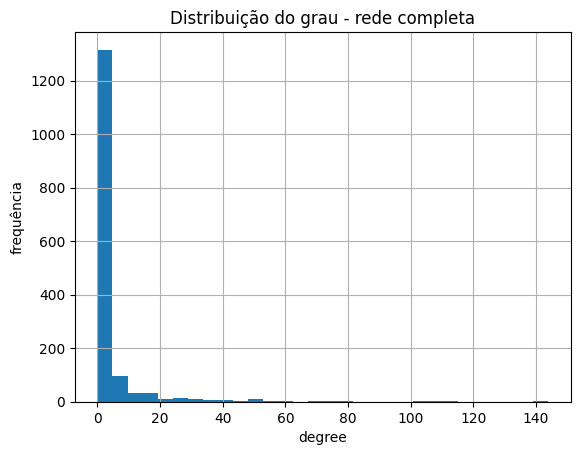

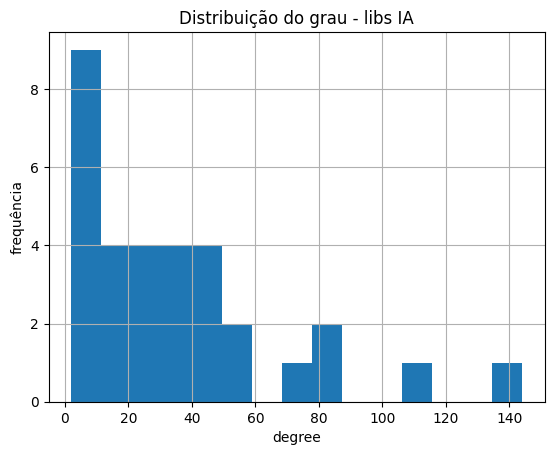

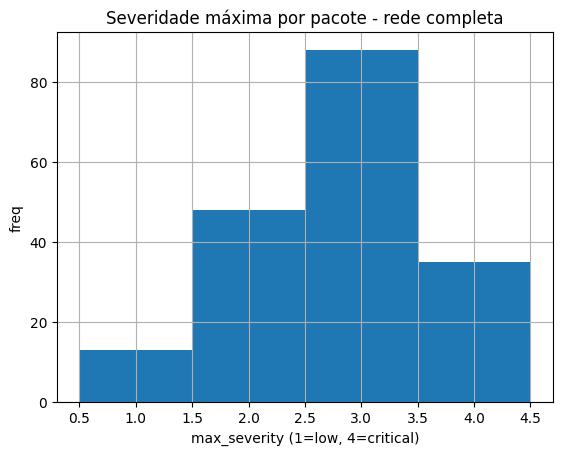

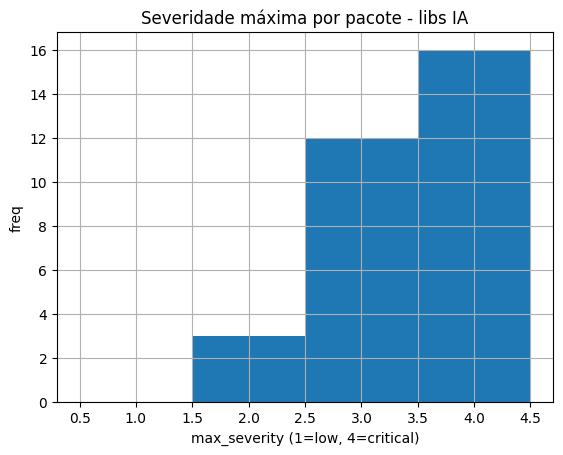

In [18]:
# =========================
# Visualizações simples: distribuição de grau e severidade
# =========================

plt.figure()
nodes_total["degree"].hist(bins=30)
plt.title("Distribuição do grau - rede completa")
plt.xlabel("degree")
plt.ylabel("frequência")
plt.show()

plt.figure()
nodes_ai["degree"].hist(bins=15)
plt.title("Distribuição do grau - libs IA")
plt.xlabel("degree")
plt.ylabel("frequência")
plt.show()

# Comparação de severidade máxima (1=low .. 4=critical)
plt.figure()
nodes_total["max_severity"].hist(bins=[0.5,1.5,2.5,3.5,4.5])
plt.title("Severidade máxima por pacote - rede completa")
plt.xlabel("max_severity (1=low, 4=critical)")
plt.ylabel("freq")
plt.show()

plt.figure()
nodes_ai["max_severity"].hist(bins=[0.5,1.5,2.5,3.5,4.5])
plt.title("Severidade máxima por pacote - libs IA")
plt.xlabel("max_severity (1=low, 4=critical)")
plt.ylabel("freq")
plt.show()

In [19]:
# =========================
# Comunidades contendo libs IA (visão rápida)
# =========================

# Mapeia cada nó para o ID da comunidade (0..N-1)
node_to_comm = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_comm[node] = i

nodes_df["community_id"] = nodes_df["package"].map(node_to_comm)

ai_communities = (
    nodes_df[nodes_df["is_ai_lib"] == True]
    .groupby("community_id")
    .size()
    .sort_values(ascending=False)
)

print("Comunidades (community_id) com mais libs IA:")
display(ai_communities.head(10))

print("\nExemplo de comunidade com libs IA (top 1):")
if not ai_communities.empty:
    top_comm_id = ai_communities.index[0]
    display(nodes_df[nodes_df["community_id"] == top_comm_id][["package", "is_ai_lib", "degree", "max_severity"]]
            .sort_values("is_ai_lib", ascending=False))

Comunidades (community_id) com mais libs IA:


community_id
0     19
2      4
3      4
7      2
1      1
4      1
10     1
dtype: int64


Exemplo de comunidade com libs IA (top 1):


,package,is_ai_lib,degree,max_severity
993,llama-index-cli,True,4,3.0
433,clearml,True,21,3.0
1254,sagemaker,True,78,3.0
639,langchain-community,True,16,3.0
926,langchain-core,True,12,2.0
...,...,...,...,...
988,llama-index-indices-managed-llama-cloud,False,1,NaN
989,llama-index-readers-file,False,1,NaN
991,llama-index-readers-llama-parse,False,1,NaN
992,llama-index-embeddings-openai,False,2,NaN
